In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
# Read data
description = pd.read_csv("columns_description.csv")
train_data = pd.read_csv("application_train.csv")
test_data = pd.read_csv("application_test.csv")

# Data exploration
print(train_data.describe())
print(train_data.describe(include="all"))
print(train_data.dtypes)
numerical_features = train_data.select_dtypes(include=["float64", "int64"]).columns
categorical_features = train_data.select_dtypes(include=["object"]).columns
print(numerical_features)
print(categorical_features)

          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL   
count  307511.000000  307511.000000  307511.000000      3.075110e+05  \
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE   
count  3.075110e+05  307499.000000     3.072330e+05  \
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05  

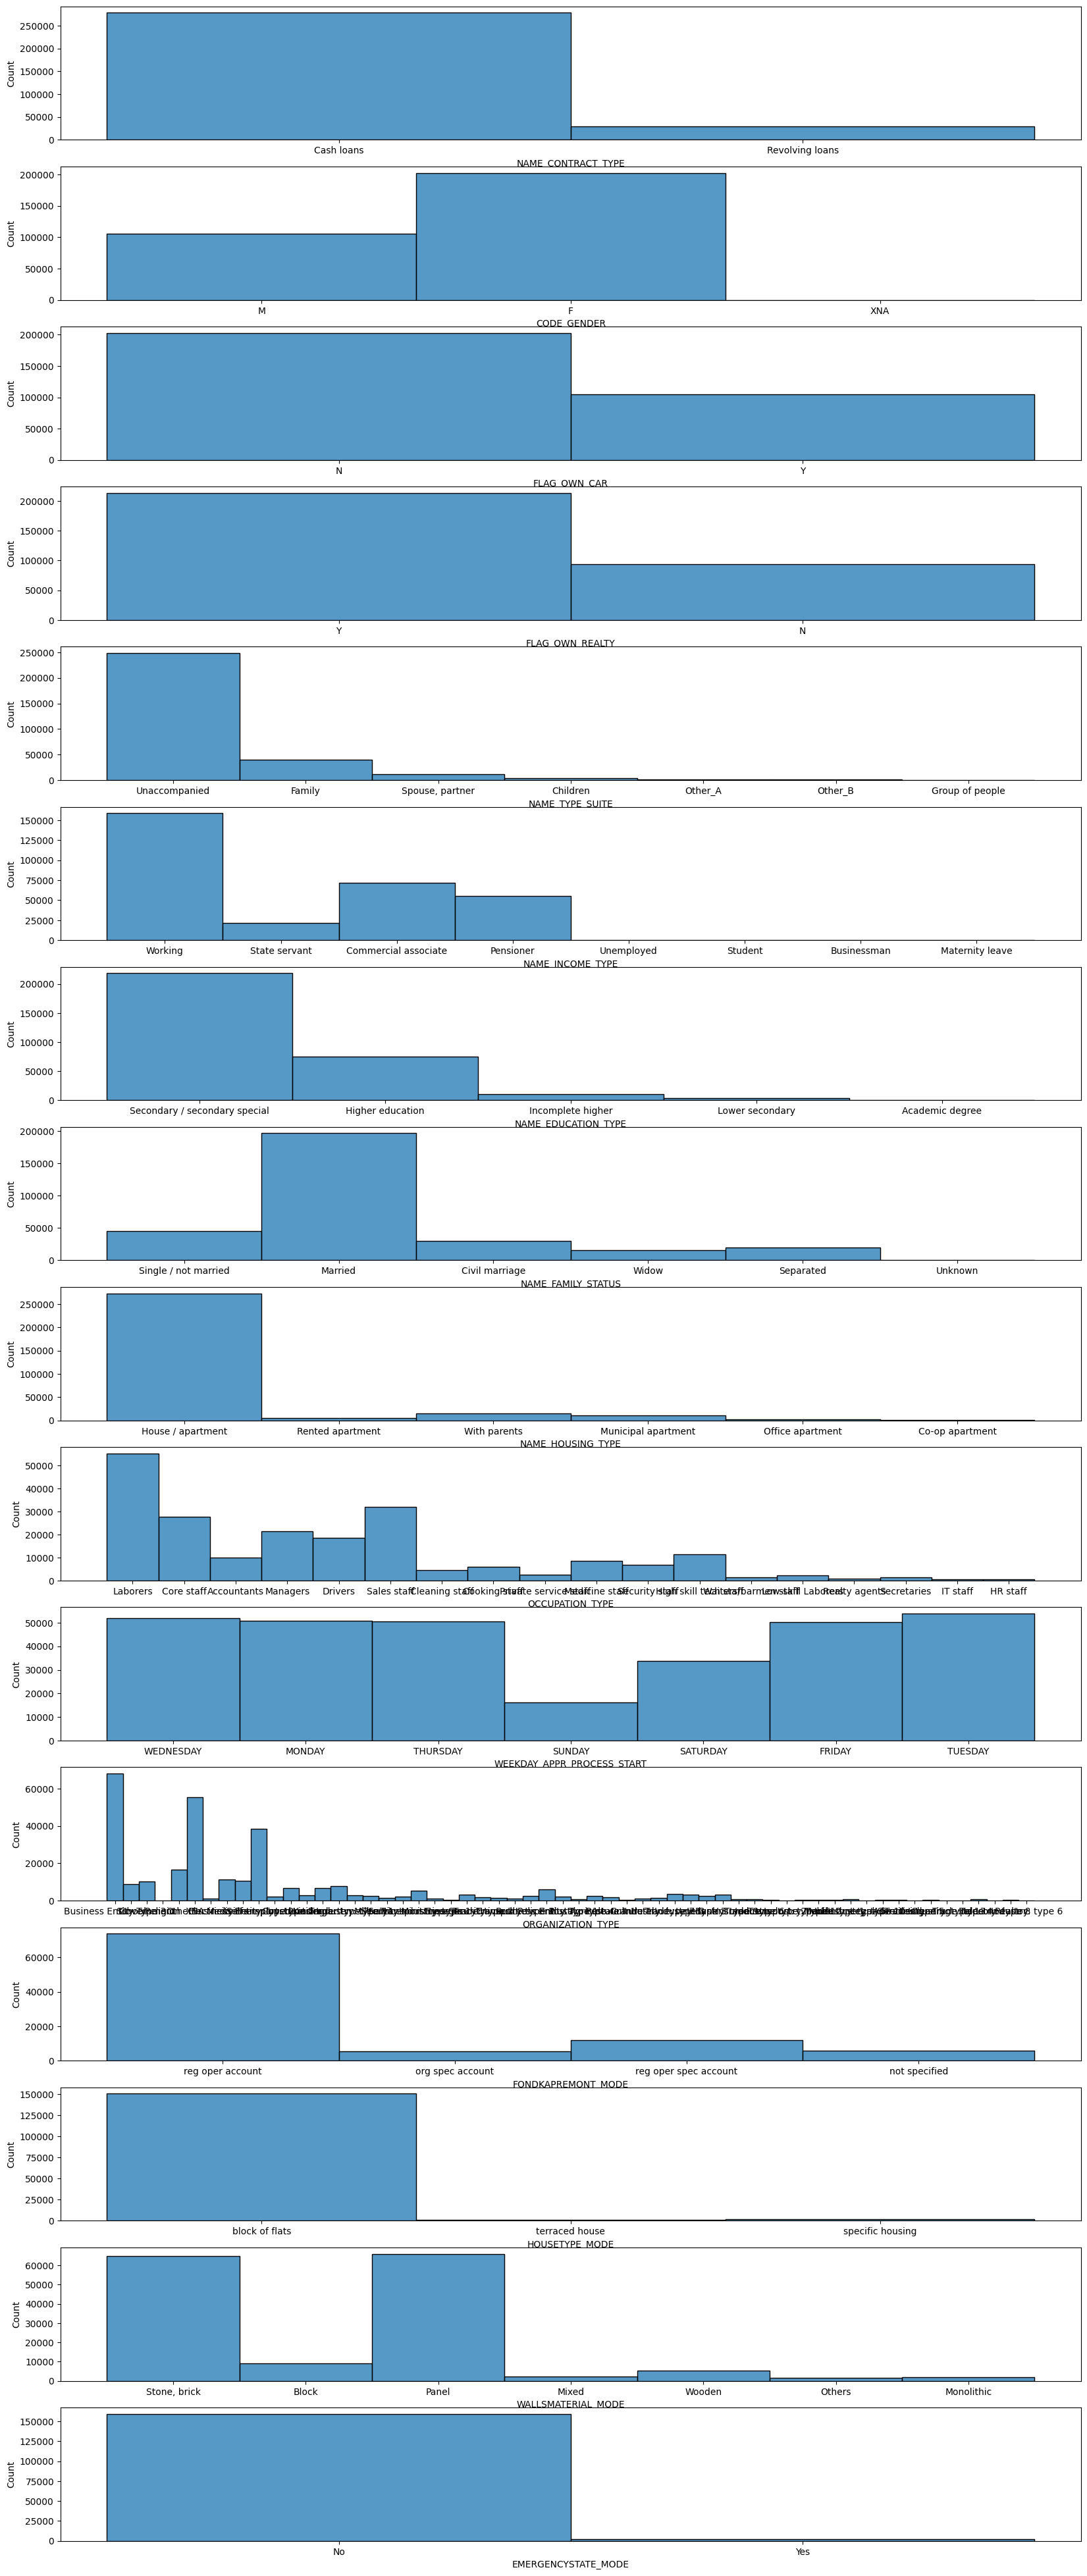

In [4]:
# Histogram plots for categorical and numerical features
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(20, 50))
for i, col in enumerate(categorical_features):
    sns.histplot(train_data[col], kde=False, ax=axes[i])
plt.show()

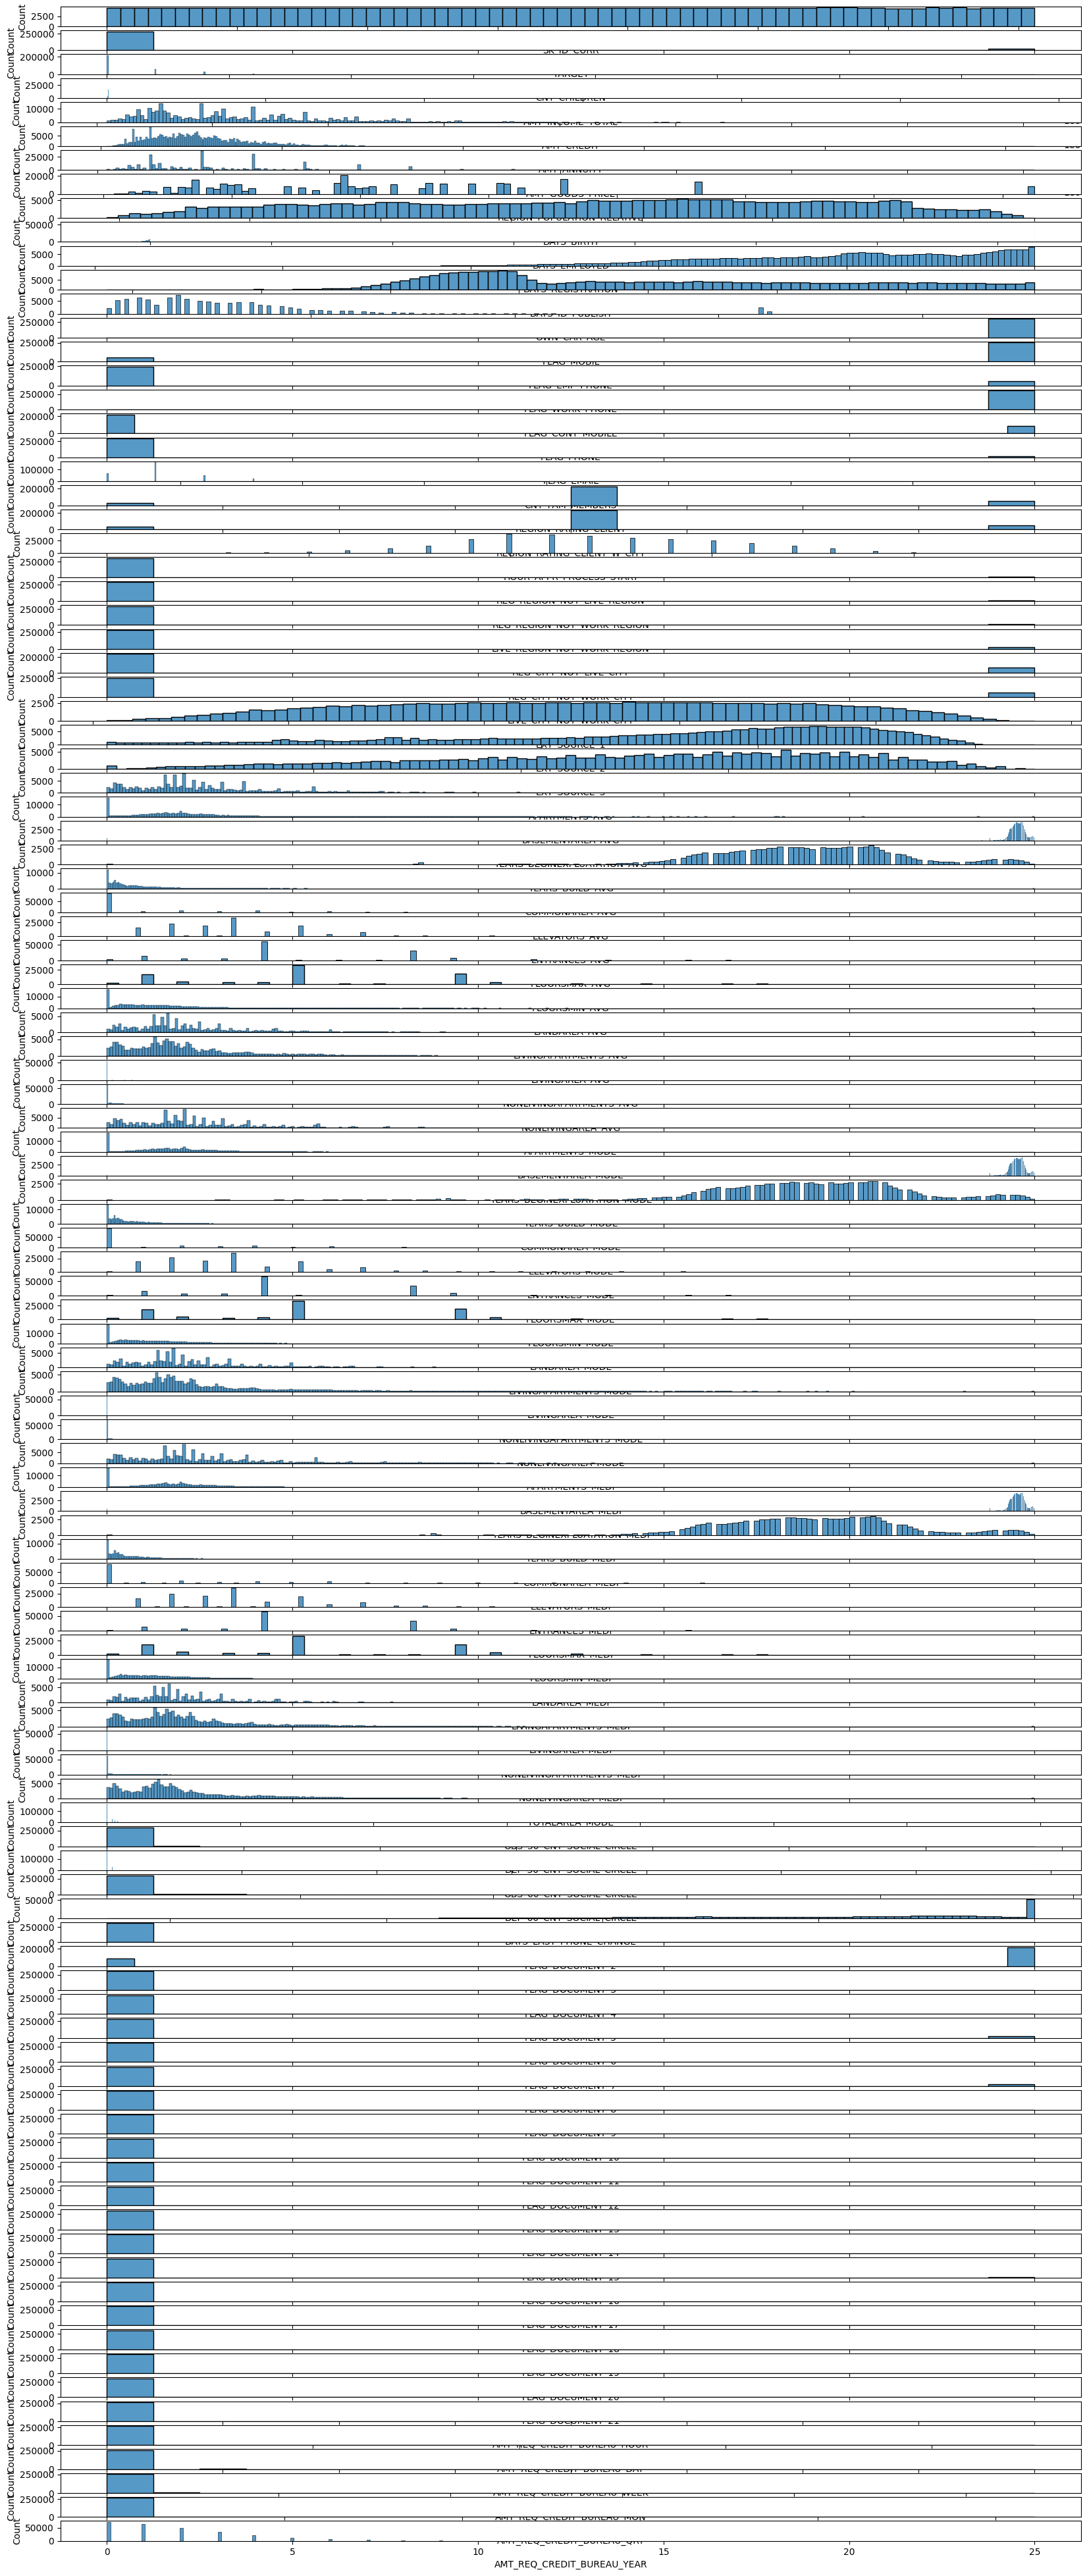

In [5]:
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(20, 50))
for i, col in enumerate(numerical_features):
    sns.histplot(train_data[col], kde=False, ax=axes[i])
plt.show()

In [6]:
# Check for duplicates and missing values
print(train_data.duplicated().sum())
print(train_data.isnull().sum())

0
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64


In [18]:
# Data preprocessing
test_data["TARGET"] = 0
features_for_test = []
for feature in train_data.columns:
    if not train_data[feature].isnull().values.any():
        features_for_test.append(feature)

# Drop the features not in test data
test_features = set(test_data.columns)
for feature in features_for_test:
    if feature not in test_features:
        features_for_test.remove(feature)

test = train_data[features_for_test].drop("TARGET", axis=1)
testDataset = test_data[features_for_test].drop("TARGET", axis=1)
numerical = test.select_dtypes(include=["float64", "int64"]).columns
categorical = test.select_dtypes(include=["object"]).columns

In [19]:
# One-hot encoding and standard scaling
transformer = ColumnTransformer(transformers=[
    ("categorical", OneHotEncoder(), categorical),
    ("numerical", StandardScaler(), numerical)],
)

fit_train_data = pd.DataFrame(transformer.fit_transform(test))
fit_test_data = pd.DataFrame(transformer.transform(testDataset))

In [25]:
# Split data into train and validation sets
x_train_split, validate_x, y_train_split, validate_y = train_test_split(
    fit_train_data, train_data["TARGET"], test_size=0.25)

# Train a logistic regression model
model = LogisticRegression(class_weight = "balanced", max_iter=3000).fit(x_train_split, y_train_split)
predictionTrain = model.predict(x_train_split)
validate = model.predict(validate_x)

In [26]:
# Evaluate the model
print("Training Accuracy: ", accuracy_score(y_train_split, predictionTrain))
print("Training ROC_AUC: ", roc_auc_score(y_train_split, predictionTrain))
print("Validation Accuracy: ", accuracy_score(validate_y, validate))
print("Validation ROC_AUC: ", roc_auc_score(validate_y, validate))

Training Accuracy:  0.6192218806502106
Training ROC_AUC:  0.6230794837629651
Validation Accuracy:  0.6184083873149666
Validation ROC_AUC:  0.6226992130379293


In [27]:
# Make predictions on test data and save to a CSV file
test_predictions = model.predict(fit_test_data)
submission_df = pd.DataFrame({"SK_ID_CURR": test_data["SK_ID_CURR"], "TARGET": test_predictions})
submission_df.to_csv("submission.csv", index=False)

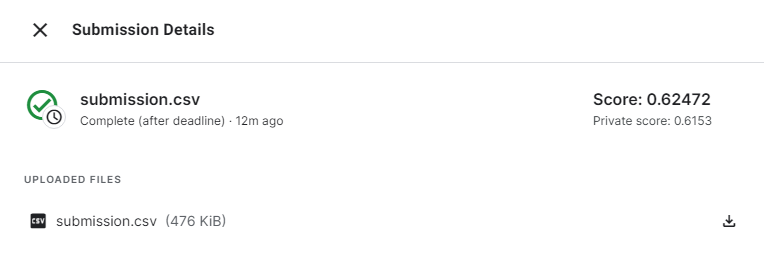